# Clustering and Associate Rule Mining
## Data used for machine learning
There are 2 csv files provided for this assignment. The first csv file is about the location of clients and provides the columns "clientid", "x", and "y". "clientid" is simply the id of each client, while x and y are coordinates. The second csv file is about transactions. It has the columns ID, Prod1, prod2... Prod20. ID is the id of the transaction, while Prod's are a binary variable that show if a product from a certain group was a part of the transaction.
## Goals of the assignment
There are 2 goals to this assignment. The first goal is to use clustering to find the optimal locations for depots. The second is to use associate rule mining to find interesting relationships between product groups.

Here are all the imports.

In [49]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Goal 1: Findig optimal locations for depots using clustering.
First the location of the clients are shown in a scatterplot.

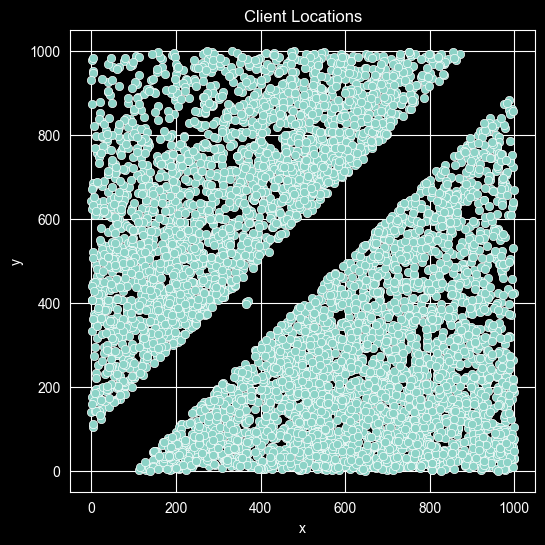

In [50]:
clientLocations = pd.read_csv("drone_cust_locations.csv", sep=";")
clientLocations = clientLocations.rename(columns={"clientid": "ID"})
Transactions = pd.read_csv("drone_prod_groups.csv")
Transactions.columns = Transactions.columns.str.strip()

plt.figure(figsize=(6,6))
sns.scatterplot(data=clientLocations, x="x", y="y")
plt.title("Client Locations")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

There is a bizarre diagonal line of absence. This would indicate that the best value to use for clusters 2.

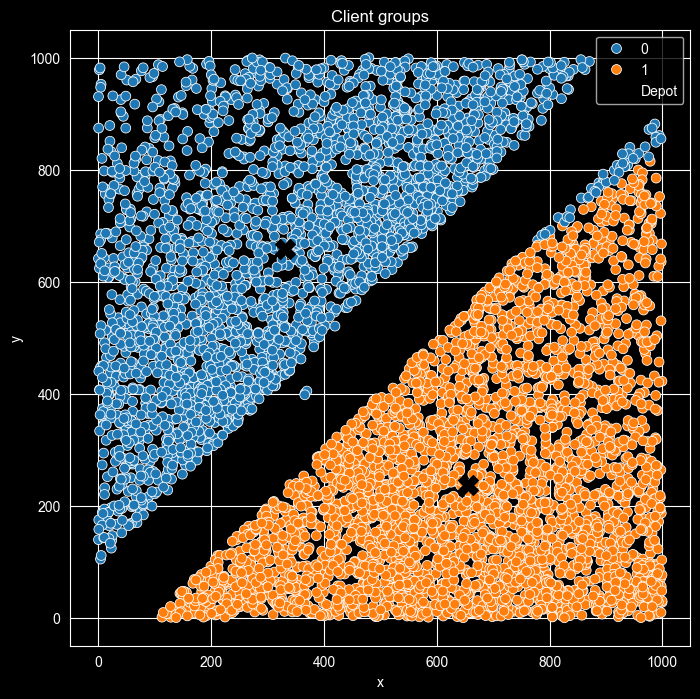

            x           y
0  330.689565  658.710541
1  655.143325  237.681867


In [57]:
depotAmount = 2
modelCluster = KMeans(init='random', n_clusters=depotAmount, random_state=5040)
modelCluster.fit(clientLocations[["x", "y"]])
clientLocations["closest_depot"] = modelCluster.labels_

depots = pd.DataFrame(modelCluster.cluster_centers_, columns=["x", "y"])

plt.figure(figsize=(8,8))

sns.scatterplot(
    data=clientLocations,
    x="x",
    y="y",
    hue="closest_depot",
    palette="tab10",
    legend="full",
    s=50
)

plt.scatter(
    depots["x"],
    depots["y"],
    color="black",
    marker="X",
    s=200,
    label="Depot"
)

plt.title("Client groups")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Here the same thing is done, expect using hierarchical clustering:

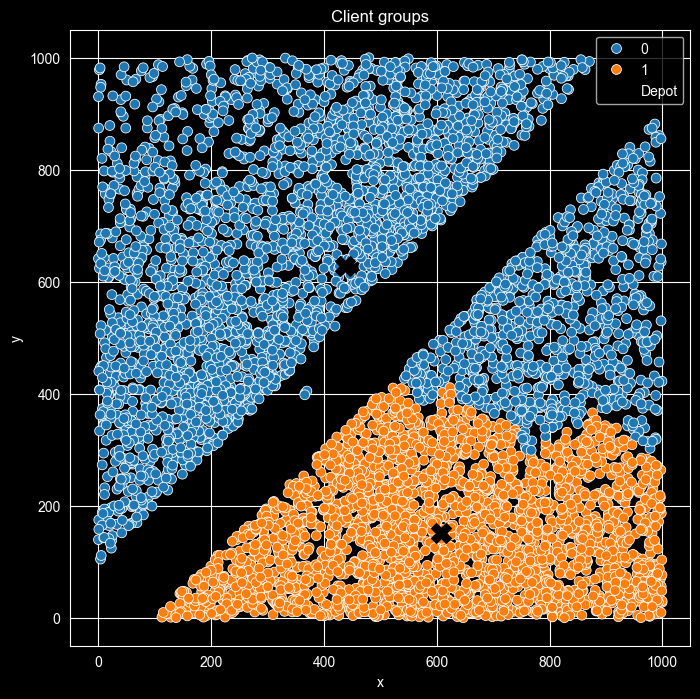

In [52]:
depotAmount = 2
modelHierarchy = AgglomerativeClustering(n_clusters=depotAmount, metric="euclidean", linkage="ward")

clientLocations["closest_depot"] = modelHierarchy.fit_predict(clientLocations[["x", "y"]])
depots = clientLocations.groupby("closest_depot")[["x", "y"]].mean().reset_index()
depots["depot_id"] = ["D"+str(i+1) for i in range(depotAmount)]

plt.figure(figsize=(8,8))

sns.scatterplot(
    data=clientLocations,
    x="x",
    y="y",
    hue="closest_depot",
    palette="tab10",
    legend="full",
    s=50
)

plt.scatter(
    depots["x"],
    depots["y"],
    color="black",
    marker="X",
    s=200,
    label="Depot"
)

plt.title("Client groups")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Interestingly enough, using hierarchical clustering provides a rather different result.
## Goal 2: Finding interesting relationships using associate data mining.
First a new dataframe is made using the old dataframe for transactions. This new dataframe drops the clientid column, and replaces the values of 0, and 1, with proper boolean values. Then we check to see frequent itemsets.

In [53]:
df = Transactions.drop(columns='ID')

df = df.fillna(False)
df = df.apply(lambda x: x.map(lambda y: True if y == 1.0 else False))

frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.10998,(Prod1)
1,0.13098,(Prod2)
2,0.10459,(Prod5)
3,0.13499,(Prod7)
4,0.16179,(Prod8)
5,0.19853,(Prod9)
6,0.10848,(Prod11)
7,0.15971,(Prod12)
8,0.14557,(Prod14)
9,0.11880,(Prod15)


This did not produce many interesting results. Let's see what results we get if we search for relationships and use confidence as our metric.

In [54]:
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(by='confidence', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Prod15),(Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663,0.541335,0.922806,0.749754
3,(Prod20),(Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849,0.613997,0.887449,0.782007
2,(Prod19),(Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508,0.613997,0.593144,0.782007
1,(Prod9),(Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664,0.541335,0.502243,0.749754


Let's do the same thing again, expect use lift as our metric.

In [55]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=2)
rules = rules.sort_values(by='lift', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Prod15),(Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663,0.541335,0.922806,0.749754
1,(Prod9),(Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664,0.541335,0.502243,0.749754
2,(Prod19),(Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508,0.613997,0.593144,0.782007
3,(Prod20),(Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849,0.613997,0.887449,0.782007


It seems like there is a strong correlation with prod9 and prod15, also with prod19 and prod20. To increase revenue, the company should consider storing them in the same depots. When a customer buys a product, it would be wise to advertise different products that have a strong relationship to the previous bought products.